# gridplot.ipynb

This notebook creates a gridplot that shows the fraction of surfaces within an optimal band for various bimetallics and monometallics.

In [1]:
import pickle
import re
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [2]:
rcParams.update({'font.sans-serif': 'Helvetica'})
rcParams.update({'font.family': 'sans-serif'})
rcParams.update({'font.size': 7})
rcParams.update({'savefig.dpi': 600})

# Initialize
Decide on the system we'll be studying and other various parameters that follow.

## HER

In [2]:
#ads = 'H'
#ads_comp = set('H')
#ref_el = 'Pt'
#dE_min = -0.47
#dE_max = -0.17
## What to put on the y-label of the plot
#label_text = 'Fraction of Surfaces with Near-Optimal $\Delta E_H$'
## What to save the gridplot as
#file_name = 'grid_her.pdf'
#
## Open the results and predictions
#with open('../HER_predictions.pkl', 'rb') as f:
#    dft_results, ml_results = pickle.load(f)

## CO2RR

In [3]:
ads = 'CO'
ads_comp = set(['C', 'O'])
ref_el = 'Cu'
dE_min = -0.77
dE_max = -0.57
# What to put on the y-label of the plot
label_text = 'Fraction of Surfaces with Near-Optimal $\Delta E_{CO}$'
# What to save the gridplot as
file_name = 'grid_co2rr.pdf'

# Open the results and predictions
with open('../CO2RR_predictions.pkl', 'rb') as f:
    dft_results, ml_results = pickle.load(f)

In [4]:
def find_composition(result):
    '''
    A function that finds the composition of a single result
    '''
    # Find the elements that are present in the structure
    elements = re.findall("[A-Z][a-z']*", result[0]['formula'])
    # Pick out the adsorbates and then return
    comp = [el for el in elements if el not in ads_comp and el != 'U']
    return comp

# Find all of the unique elements
dft_comps = [find_composition(result) for result in dft_results]
ml_comps = [find_composition(result) for result in ml_results]
unique_elements = list(set(element for comp in dft_comps+ml_comps
                           for element in comp))

# Parse the data

## Decide if we're plotting DFT, DFT+ML, or ML

In [17]:
# DFT only
results = dft_results
compositions = dft_comps

## DFT+ML
#results = dft_results + ml_results
#compositions = dft_comps + ml_comps

## ML
#results = ml_results
#compositions = ml_comps

# Rank-order the elements

In [6]:
# Get the average CO binding energy of each pure element
avg_dEs = []
for i, el in enumerate(unique_elements):
    energies = []
    for result, comp in zip(results, compositions):
        if el in comp and len(comp) == 1:
            energy = result[1][0][0]
            energies.append(energy)
    avg_dEs.append(np.mean(energies))

# Sort the element list by the average adsorption energies. It looks
# complicated because Python's `sorted` function can't actually sort NaN
real_sort_list = [(energy, el) for energy, el in zip(avg_dEs, unique_elements)
                  if not np.isnan(energy)]
unique_elements_sorted = [el for _, el in reversed(sorted(real_sort_list))]
for energy, el in zip(avg_dEs, unique_elements):
    if np.isnan(energy):
        unique_elements_sorted.append(el)

# Remove S and Se because they're group 16 and probably wrong
del unique_elements_sorted[unique_elements_sorted.index('S')]
del unique_elements_sorted[unique_elements_sorted.index('Se')]
# Remove a few more because they're new and we have little data on them
del unique_elements_sorted[unique_elements_sorted.index('Ca')]
del unique_elements_sorted[unique_elements_sorted.index('Na')]
del unique_elements_sorted[unique_elements_sorted.index('Nb')]
del unique_elements_sorted[unique_elements_sorted.index('Cd')]

# Print out the average energy for the reference element
print('The average binding energy of %s on %s is %.2f eV'
      % (ads, ref_el, avg_dEs[unique_elements.index(ref_el)]))

The average binding energy of CO on Cu is -0.66 eV


/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Parse the data before plotting

In [18]:
# Create matrices that contain the number of surfaces we have
# in each bimetallic pairing and the number of ones within optimum
# range, respectively.
surface_counts = np.zeros((len(unique_elements), len(unique_elements)))
optimal_surface_counts = np.zeros((len(unique_elements), len(unique_elements)))
for i, el_i in enumerate(unique_elements_sorted):
    for j, el_j in enumerate(unique_elements_sorted):
        # Counting for pure metals
        if i == j:
            for result, comp in zip(results, compositions):
                # Advace the count for each instance of a pure metal
                if el_i in comp and len(comp) == 1:
                    surface_counts[i, j] += 1
                    # Advance the count for pure metals within optimum range
                    energy = result[1][0][0]
                    if dE_min < energy < dE_max:
                        optimal_surface_counts[i, j] += 1

        # Counting for binary metals
        else:
            for result, comp in zip(results, compositions):
                # Advace the count for each instance of a bimetallic
                if (el_i in comp) and (el_j in comp) and (len(comp) == 2):
                    surface_counts[i, j] += 1
                    # Advance the count for pure metals within optimum range
                    energy = result[1][0][0]
                    if dE_min < energy < dE_max:
                        optimal_surface_counts[i, j] += 1

# Calculate the fraction of optimal surfaces
optimal_fractions = optimal_surface_counts/surface_counts

/global/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide


# Plot (DFT)

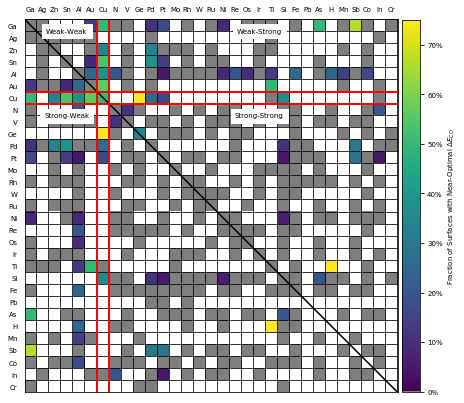

In [19]:
# Initialize
fig = plt.figure(figsize=(7.08661, 7.08661))
ax = fig.add_subplot(111)
# Make the colors
new_cmap = cm.viridis.colors
new_cmap[0] = [0.5, 0.5, 0.5]
viridis_gray = ListedColormap(new_cmap, 'viridis_gray')
plt.register_cmap(cmap=viridis_gray)

# Make the gridplot
cax = ax.matshow(optimal_fractions, cmap='viridis_gray')
# Make the parity line
plt.plot([-1, len(unique_elements_sorted)], [-1, len(unique_elements_sorted)], 'k-')
# Make the red lines encasing the reference element
reference_index = unique_elements_sorted.index(ref_el)
plt.plot([-0.5, len(unique_elements_sorted)], [reference_index-0.5, reference_index-0.5],
         'r', linewidth=2)
plt.plot([-0.5, len(unique_elements_sorted)], [reference_index+0.5, reference_index+0.5],
         'r', linewidth=2)
plt.plot([reference_index-0.5, reference_index-0.5], [-0.5, len(unique_elements_sorted)],
         'r', linewidth=2)
plt.plot([reference_index+0.5, reference_index+0.5], [-0.5, len(unique_elements_sorted)],
         'r', linewidth=2)

# Make the colorbar
cb = fig.colorbar(cax, fraction=0.047, pad=0.01)
cb.set_label(label_text, rotation=90)
ticks = cb.ax.get_yticklabels()
for tick in ticks:
    tick._text = '%.0f%%'%(float(tick._text)*100)
cb.ax.set_yticklabels(ticks)
# Label the elements on the x and y axes
ax.set_xticklabels([''] + unique_elements_sorted)
ax.set_yticklabels([''] + unique_elements_sorted)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Zoom correctly and do some other formatting touch-ups
plt.xlim([0-0.5, len(unique_elements_sorted)-0.5])
plt.ylim([len(unique_elements_sorted)-0.5, -0.5])
plt.grid(which='minor', b=True)
plt.minorticks_on()
ax.xaxis.set_minor_locator(ticker.IndexLocator(base=1, offset=0.47))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=1, offset=0.47))
plt.grid(b=True, which='minor', color='k', linestyle='-')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelright='off') # labels along the bottom edge are off

# Label the quadrants
plt.text(3, 0.5, 'Weak-Weak',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(19, 0.5, 'Weak-Strong',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(3, 7.5, 'Strong-Weak',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(19, 7.5, 'Strong-Strong',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')

plt.savefig('dft_' + file_name)

# Plot (ML)

In [20]:
## DFT only
#results = dft_results
#compositions = dft_comps

## DFT+ML
#results = dft_results + ml_results
#compositions = dft_comps + ml_comps

# ML
results = ml_results
compositions = ml_comps

In [21]:
# Create matrices that contain the number of surfaces we have
# in each bimetallic pairing and the number of ones within optimum
# range, respectively.
surface_counts = np.zeros((len(unique_elements), len(unique_elements)))
optimal_surface_counts = np.zeros((len(unique_elements), len(unique_elements)))
for i, el_i in enumerate(unique_elements_sorted):
    for j, el_j in enumerate(unique_elements_sorted):
        # Counting for pure metals
        if i == j:
            for result, comp in zip(results, compositions):
                # Advace the count for each instance of a pure metal
                if el_i in comp and len(comp) == 1:
                    surface_counts[i, j] += 1
                    # Advance the count for pure metals within optimum range
                    energy = result[1][0][0]
                    if dE_min < energy < dE_max:
                        optimal_surface_counts[i, j] += 1

        # Counting for binary metals
        else:
            for result, comp in zip(results, compositions):
                # Advace the count for each instance of a bimetallic
                if (el_i in comp) and (el_j in comp) and (len(comp) == 2):
                    surface_counts[i, j] += 1
                    # Advance the count for pure metals within optimum range
                    energy = result[1][0][0]
                    if dE_min < energy < dE_max:
                        optimal_surface_counts[i, j] += 1

# Calculate the fraction of optimal surfaces
optimal_fractions = optimal_surface_counts/surface_counts

/global/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide


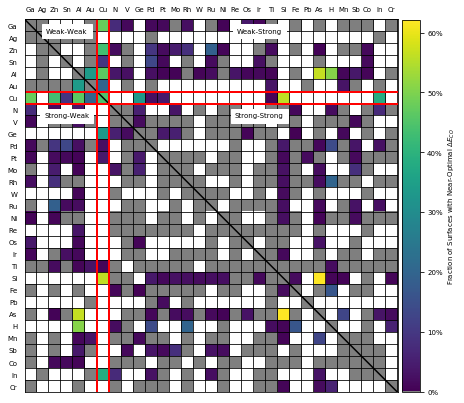

In [22]:
# Initialize
fig = plt.figure(figsize=(7.08661, 7.08661))
ax = fig.add_subplot(111)
# Make the colors
new_cmap = cm.viridis.colors
new_cmap[0] = [0.5, 0.5, 0.5]
viridis_gray = ListedColormap(new_cmap, 'viridis_gray')
plt.register_cmap(cmap=viridis_gray)

# Make the gridplot
cax = ax.matshow(optimal_fractions, cmap='viridis_gray')
# Make the parity line
plt.plot([-1, len(unique_elements_sorted)], [-1, len(unique_elements_sorted)], 'k-')
# Make the red lines encasing the reference element
reference_index = unique_elements_sorted.index(ref_el)
plt.plot([-0.5, len(unique_elements_sorted)], [reference_index-0.5, reference_index-0.5],
         'r', linewidth=2)
plt.plot([-0.5, len(unique_elements_sorted)], [reference_index+0.5, reference_index+0.5],
         'r', linewidth=2)
plt.plot([reference_index-0.5, reference_index-0.5], [-0.5, len(unique_elements_sorted)],
         'r', linewidth=2)
plt.plot([reference_index+0.5, reference_index+0.5], [-0.5, len(unique_elements_sorted)],
         'r', linewidth=2)

# Make the colorbar
cb = fig.colorbar(cax, fraction=0.047, pad=0.01)
cb.set_label(label_text, rotation=90)
ticks = cb.ax.get_yticklabels()
for tick in ticks:
    tick._text = '%.0f%%'%(float(tick._text)*100)
cb.ax.set_yticklabels(ticks)
# Label the elements on the x and y axes
ax.set_xticklabels([''] + unique_elements_sorted)
ax.set_yticklabels([''] + unique_elements_sorted)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Zoom correctly and do some other formatting touch-ups
plt.xlim([0-0.5, len(unique_elements_sorted)-0.5])
plt.ylim([len(unique_elements_sorted)-0.5, -0.5])
plt.grid(which='minor', b=True)
plt.minorticks_on()
ax.xaxis.set_minor_locator(ticker.IndexLocator(base=1, offset=0.47))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=1, offset=0.47))
plt.grid(b=True, which='minor', color='k', linestyle='-')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelright='off') # labels along the bottom edge are off

# Label the quadrants
plt.text(3, 0.5, 'Weak-Weak',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(19, 0.5, 'Weak-Strong',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(3, 7.5, 'Strong-Weak',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')
plt.text(19, 7.5, 'Strong-Strong',
         horizontalalignment='center', verticalalignment='center', backgroundcolor='w')

plt.savefig('ml_' + file_name)